<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Laplace_On_Disc/LaplaceOnDisc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from jax import random
from jax import lax

import jax.numpy as jnp
import numpy as np

import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from functools import partial

In [2]:
def poisson_kernel(r, theta):
  return (1 - jnp.power(r, 2)) / (1 - 2 * r * jnp.cos(theta) + jnp.power(r, 2))

In [3]:
def metroStep(cur, prop, kernel, r, theta):
  k1 = kernel(r, theta-prop[0])
  k2 = kernel(r, theta-cur)
  A = jnp.minimum(1, jnp.divide(k1,k2)) - prop[1]
  Y = jnp.ceil(A)
  out = jnp.multiply(cur, 1-Y) + jnp.multiply(prop[0], Y)
  return out, (out, jnp.array([0.0]))


def solve_at_point(g, k, r, theta, batches, t, key):
  keys = random.split(key, 2)

  proposals = random.uniform(keys[0], shape=(t, batches, len(r), len(theta))) * 2 * jnp.pi
  U = random.uniform(keys[1], shape=(t-1, batches, len(r), len(theta)))
  
  r = jnp.array(r)
  r = jnp.reshape(r, (1,len(r),1))
  theta = jnp.array(theta)
  theta = jnp.reshape(theta, (1,1,len(theta)))

  metroFunc = partial(metroStep, kernel=poisson_kernel, r=r, theta=theta)
  final, result = lax.scan(metroFunc, proposals[0], (proposals[1:], U))
  t_mean = jnp.mean(g(result[0]), axis=0)
  batch_mean = jnp.mean(t_mean, axis=0)
  return batch_mean

CPU times: user 3.25 s, sys: 113 ms, total: 3.36 s
Wall time: 2.47 s


/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


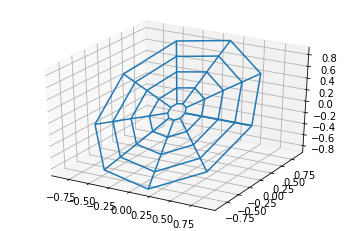

In [20]:
%%time
batches = 50
t = 10000
r = jnp.linspace(0.1,0.9,num=5)
theta = jnp.linspace(0,2*jnp.pi,num=10)
key = random.PRNGKey(0)
ans = solve_at_point(jnp.sin, poisson_kernel, r, theta, batches, t, key)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = np.outer(r, np.cos(theta))
y = np.outer(r, np.sin(theta))
z = np.array(ans)

#ax.scatter(x,y,z)
ax.plot_wireframe(x, y, z)